In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import random
# import datetime
import matplotlib.pyplot as plt
# import scipy.stats
import seaborn as sns
from numpy.linalg import inv
%matplotlib inline

In [2]:
tickers_stocks = ['AMZN', 'NVDA', "AAPL", "GOOG", "FB"]
rf = .055

In [3]:
data = pdr.data.DataReader(tickers_stocks, 'yahoo', start='2018/01/01', end='2021/05/01')
data = data['Adj Close']

data.head()

Symbols,AMZN,NVDA,AAPL,GOOG,FB
Date,,,,,
2018-01-02,1189.010010,49.372395,41.075405,1065.000000,181.419998
2018-01-03,1204.199951,52.621773,41.068264,1082.479980,184.669998
2018-01-04,1209.589966,52.899162,41.259007,1086.400024,184.330002
2018-01-05,1229.140015,53.347450,41.728748,1102.229980,186.850006
2018-01-08,1246.869995,54.982044,41.573765,1106.939941,188.279999


In [4]:
# Log-rendimientos
df_log = np.log(data.pct_change()+1)
df_log.head()

Symbols,AMZN,NVDA,AAPL,GOOG,FB
Date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.012694,0.063739,-0.000174,0.016280,0.017756
2018-01-04,0.004466,0.005258,0.004634,0.003615,-0.001843
2018-01-05,0.016033,0.008439,0.011321,0.014466,0.013579
2018-01-08,0.014322,0.030180,-0.003721,0.004264,0.007624


In [5]:
returns_annual = df_log.mean() * 250
cov_daily = df_log.cov()
cov_annual = cov_daily * 250

returns_annual

Symbols
AMZN    0.319680
NVDA    0.331893
AAPL    0.345251
GOOG    0.243937
FB      0.174210
dtype: float64

In [6]:
cov_annual

Symbols,AMZN,NVDA,AAPL,GOOG,FB
Symbols,,,,,
AMZN,0.104616,0.102165,0.073800,0.067350,0.077353
NVDA,0.102165,0.247969,0.113455,0.097973,0.108270
AAPL,0.073800,0.113455,0.119673,0.072173,0.080774
GOOG,0.067350,0.097973,0.072173,0.093570,0.080028
FB,0.077353,0.108270,0.080774,0.080028,0.142584


In [7]:
def mvp_portfolio(Cov, E):
    '''
    Return mvp porfolio
    '''
    inv_Cov = inv(Cov)
    M_1 = np.zeros((Cov.shape[0],)) + 1

    num = inv_Cov @ M_1
    dem = M_1.T @ inv_Cov @ M_1

    W_mvp = num/dem
    

    r_mvp = W_mvp.T @ E
    var_mvp = W_mvp.T @ Cov @ W_mvp
    std_mvp = var_mvp**0.5
    
    print(f'Pesos: {W_mvp}')
    print(f'Rendimiento: {r_mvp}')
    print(f'Volatilidad: {std_mvp}')

    return r_mvp, std_mvp


def tangency_portfolio(Cov, E, rf):
    '''
    Return tangency porfolio with risk free asset
    '''
    
    inv_Cov = inv(Cov)  
    z = inv_Cov @ (E-rf)   
    z /= np.sum(z)
    
    r_tg = z.T @ E
    var_tg = z.T @ Cov @ z
    std_tg = var_tg**0.5

    return r_tg, std_tg


r_mvp, std_mvp = mvp_portfolio(cov_annual, returns_annual)
r_tg, std_tg = tangency_portfolio(cov_annual, returns_annual, rf)

Pesos: [ 0.3755351  -0.17682135  0.23803881  0.51536191  0.04788553]
Rendimiento: 0.27760651594453933
Volatilidad: 0.27785435495751504


In [8]:
# Optimal portfolio
def optimal_portfolio(Cov, E, rp):
    '''
    Return efficient frontier
    '''

    M_1 = np.zeros((Cov.shape[0],)) + 1
    A = (M_1.T @ inv(Cov) @ E)
    B = (E.T @ inv(Cov) @ E)
    C = (M_1.T @ inv(Cov) @ M_1)
    D = B*C - A**2

    g = (1/D) * ((B*inv(Cov) @ M_1) - (A * inv(Cov) @ E))
    h = (1/D) * ((C * inv(Cov) @ E) - (A * inv(Cov) @ M_1))

    W = g + (h * rp)
    
    return W


# Optimal portfolio with free risk asset
def optimal_portfolio_rf(Cov, E, rp, rf):
    '''
    Return optimal porfolio with risk free asset
    '''

    M_1 = np.zeros((Cov.shape[0],)) + 1
    inv_Cov = inv(Cov)
    
    H = (E - rf).T @ inv_Cov @ (E - rf)
    
    W = inv_Cov @ (E - rf) * (rp-rf)/H
    Wf = 1 - W.sum()
    
    return W, Wf

In [9]:
def optimal_weights(n_points, er, cov,r_tg,r_mvp):
    '''
    Return n number of optimal porfolio's (efficient frontier)
    '''
    target_rs = np.linspace(r_mvp, r_tg*1.05, n_points)
    weights = [optimal_portfolio(cov, er,target_return) for target_return in target_rs]
    return weights

def optimal_weights_rf(n_points, er, cov, rf, r_mvp,r_tg):
    target_rs = np.linspace(r_mvp*1.2, r_tg*1.05, n_points)
    weights = [optimal_portfolio_rf(cov, er,target_return,rf) for target_return in target_rs]
    return weights

In [10]:
r_mvp, r_tg

(0.27760651594453933, 0.4082188847716743)

In [11]:
# weights

In [12]:
# port_returns

In [13]:
# port_volatility

In [14]:
# Efficient frontier
n_points = 50
weights = optimal_weights(n_points, returns_annual, cov_annual,r_tg,r_mvp)
port_returns = []
port_volatility = []
for w in weights:
    returns = np.dot(w, returns_annual)
    volatility = np.sqrt(np.dot(w.T, np.dot(cov_annual, w)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}
df_opt = pd.DataFrame(portfolio)
df_opt.head()

,Returns,Volatility
0,0.277607,0.277854
1,0.280689,0.277900
2,0.283771,0.278036
3,0.286853,0.278263
4,0.289935,0.278580


In [15]:
# Efficient frontier with risk free asset
n_points = 50
weights = optimal_weights_rf(n_points, returns_annual, cov_annual,rf, r_mvp,r_tg)

port_returns = []
port_volatility = []
for w,wf in weights:
    returns = np.dot(w, returns_annual) + rf*wf
    volatility = np.sqrt(np.dot(w.T, np.dot(cov_annual, w)))
    port_returns.append(returns)
    port_volatility.append(volatility)

portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}
df_opt_rf = pd.DataFrame(portfolio)
df_opt_rf.head()

,Returns,Volatility
0,0.333128,0.275595
1,0.335077,0.277526
2,0.337026,0.279457
3,0.338975,0.281388
4,0.340924,0.283320


<AxesSubplot:xlabel='Symbols', ylabel='Symbols'>

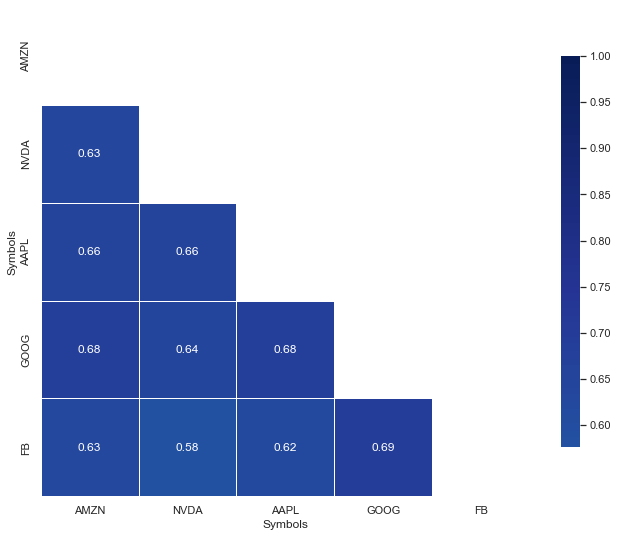

In [16]:
sns.set_theme(style="white")
corr = df_log.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap="YlGnBu", vmax=1, center=0,
            square=True, linewidths=.6, cbar_kws={"shrink": .8}, annot = True)

In [17]:
weights#.sum()

[(array([ 0.58739169, -0.05616913,  0.58126783,  0.11830984, -0.44339097]),
  0.21259074436738312),
 (array([ 0.59150792, -0.05656274,  0.58534115,  0.11913891, -0.4464981 ]),
  0.20707286099885702),
 (array([ 0.59562415, -0.05695635,  0.58941446,  0.11996798, -0.44960523]),
  0.2015549776303316),
 (array([ 0.59974039, -0.05734997,  0.59348778,  0.12079706, -0.45271235]),
  0.19603709426180593),
 (array([ 0.60385662, -0.05774358,  0.5975611 ,  0.12162613, -0.45581948]),
  0.19051921089328006),
 (array([ 0.60797285, -0.05813719,  0.60163442,  0.1224552 , -0.4589266 ]),
  0.1850013275247543),
 (array([ 0.61208908, -0.05853081,  0.60570773,  0.12328428, -0.46203373]),
  0.1794834441562283),
 (array([ 0.61620531, -0.05892442,  0.60978105,  0.12411335, -0.46514086]),
  0.17396556078770264),
 (array([ 0.62032154, -0.05931803,  0.61385437,  0.12494242, -0.46824798]),
  0.168447677419177),
 (array([ 0.62443778, -0.05971165,  0.61792769,  0.1257715 , -0.47135511]),
  0.16292979405065133),
 (arr

In [18]:
# Simulation 
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(tickers_stocks)
num_portfolios = 10000

for single_portfolio in range(num_portfolios):
    #weights = np.random.random(num_assets)
    #weights /= np.sum(weights)
    weights = np.array([random.randint(-10000, 10000) for x in range(5)],dtype=float)
    weights /= np.sum(weights)

    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))  
    
    if volatility < .38: 
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}


df = pd.DataFrame(portfolio)
df.head()

,Returns,Volatility
0,0.224154,0.326303
1,0.241602,0.293968
2,0.294202,0.379438
3,0.383622,0.342404
4,0.308134,0.360749


In [19]:
df.Returns.min()

0.1248034795132994

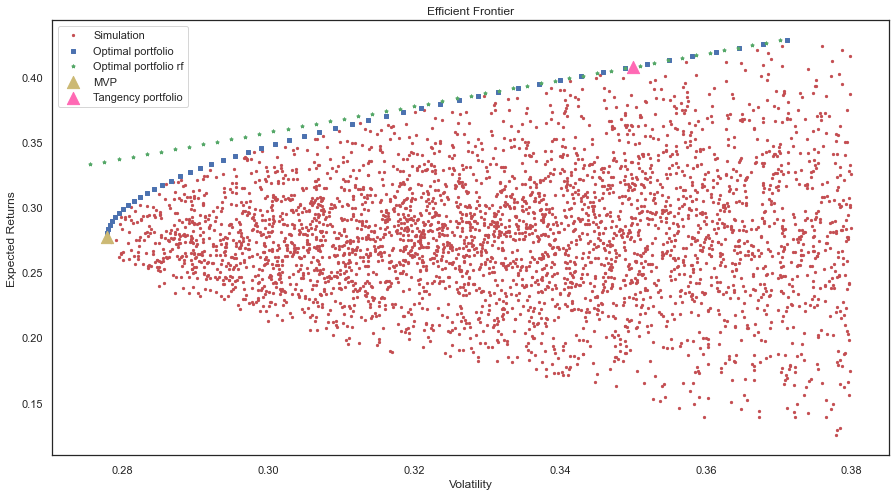

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure( figsize=(15, 8))
ax1 = fig.add_subplot(111)


ax1.scatter(df["Volatility"],df["Returns"], s=5, c='r', marker="o", label='Simulation')
ax1.scatter(df_opt["Volatility"],df_opt["Returns"], s=12, c='b', marker="s", label='Optimal portfolio')
ax1.scatter(df_opt_rf["Volatility"],df_opt_rf["Returns"], s=12, c='g', marker="*", label='Optimal portfolio rf')
ax1.scatter(std_mvp, r_mvp, s=150, c='y', marker="^", label='MVP')
ax1.scatter(std_tg, r_tg, s=150, c='hotpink', marker="^", label='Tangency portfolio')

plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')

plt.legend(loc='upper left');
plt.show()

In [21]:
r_mvp, r_tg*1.05

(0.27760651594453933, 0.42862982901025803)

In [22]:
df_opt.head()

,Returns,Volatility
0,0.277607,0.277854
1,0.280689,0.277900
2,0.283771,0.278036
3,0.286853,0.278263
4,0.289935,0.278580


In [23]:
df_opt.head(10)

,Returns,Volatility
0,0.277607,0.277854
1,0.280689,0.277900
2,0.283771,0.278036
3,0.286853,0.278263
4,0.289935,0.278580
5,0.293017,0.278987
6,0.296099,0.279484
7,0.299181,0.280070
8,0.302263,0.280744
9,0.305345,0.281507
